In [1]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import plotting.plots as myplot
from utils.read_eval import read_eval, get_recalls, merge_same_topic
from utils.parse_terrier_output import parse_stats, parse_run_results, parse_evaluation_results,parse_indexing
from utils.parse_terrier_input import read_topics

tp = ['HP04', 'NP04', 'TD04']
models = ['LogTfIdfModel', 'TF_IDF' , 'BM25', 'PL2']
query_exp = ['','-q']
combinations = [comb for comb in itertools.product(tp, models, query_exp)]

logs_path = r"C:\Users\anton\Documents\GitHub\ir-ae1\logs"

quiz_images = "quiz_images"

topics = {}
qrels = {}
for topic in tp:
    topics[topic] = r"/Users/fferegrino/Documents/ae1/TopicsQrels/%s/topics" % topic
    qrels[topic] = r"/Users/fferegrino/Documents/ae1/TopicsQrels/%s/qrels" % topic

dataframes_path= "results"

In [2]:
aggregates = {}
per_query = {}
aggregates_qe = {}
per_query_qe = {}
for topic in tp:
    aggregates[topic] = {}
    per_query[topic] = {}
    aggregates_qe[topic] = {}
    per_query_qe[topic] = {}
    for model in models:
        
        tot = pd.read_csv(os.path.join(dataframes_path, "total_%s_%s.csv" %(topic, model)), 
                          index_col=0)
        pq = pd.read_csv(os.path.join(dataframes_path, "per_query_%s_%s.csv" %(topic, model)), 
                         index_col=0)
        
        tot_qe = pd.read_csv(os.path.join(dataframes_path, "total_%s_%s-q.csv" %(topic, model)), 
                          index_col=0)
        pq_qe = pd.read_csv(os.path.join(dataframes_path, "per_query_%s_%s-q.csv" %(topic, model)), 
                         index_col=0)
        
        
        aggregates_qe[topic][model] = tot_qe
        per_query_qe[topic][model] = pq_qe
        
        aggregates[topic][model] = tot
        per_query[topic][model] = pq

## Q1

Start by using Terrier’s default indexing setup: Porter Stemming & Stopwords removed. You will need to index the collection, following the instructions in Terrier’s documentation.  

**[1 mark]**

Once you have indexed the collection, answer the Quiz questions asking you to enter your main obtained indexing statistics (number of tokens, size of files, time to index, etc).

In [3]:
info_df, time = parse_indexing(os.path.join(logs_path, "indexing-output.txt"))
print("Time to index", time, "seconds")

Time to index 1177.802 seconds


In [4]:
stats = parse_stats(os.path.join(logs_path, "stats.txt"))
for stat in stats:
    print(stat + ":", stats[stat])

number of indexed documents: 807775
size of vocabulary: 2043788
number of tokens: 572916194
number of pointers: 177737957
time elapsed: 0.02


## Q2  
Implement and add a new Simple TF IDF class in Terrier following the instructions in Terrier’s documentation. The Simple TF IDF weighting model you are required to implement is highlighted in Lecture 3. Use the template class provided in the IRcourseHM project, available from the [Github repo](https://github.com/cmacdonald/IRcourseHM).  

**[2 marks]**  

Paste your Java method code when prompted by the Quiz instance, and answer the corresponding question.

```
private final double constant = 0.5;

public double score(double tf, double docLength) {

    double score = 0;

    double numerator = (numberOfDocuments - documentFrequency) + constant;
    double denominator = documentFrequency + constant;

    score = tf * (WeightingModelLibrary.log(numerator / denominator));

    return score;
}
```

## Q3  
Now you will experiment with all four weighting models (Simple TF IDF, Terrier TF IDF, BM25 and PL2) and analyse their results on 3 different topic sets, representing different Web retrieval tasks: homepage finding (HP04), named page finding (NP04), and topic distillation (TD04). A description of these topic sets and the underlying search tasks is provided on Moodle.   

**[16 marks]** 

Provide the required MAP performances of each of the weighting models over the 3 topic sets. Report your MAP performances to 4 decimal places. Also, provide the average MAP performance of each weighting model across the three topic sets, when prompted by the Quiz instance.

In [5]:
default_models =  ['LogTfIdfModel', 'TF_IDF' , 'BM25', 'PL2']
for t in tp:
    avg = 0
    for model in default_models:
        model_avg = aggregates[t][model].iloc[0]['map']
        avg = avg + model_avg
        print("%s - %s: %.4f" % (t, 
                                 model, 
                                 model_avg))
    #print("Average for topic %.4f" % (avg / 3))
    print()

for model in default_models:
    avg = 0
    for t in tp:
        model_avg = aggregates[t][model].iloc[0]['map']
        print(aggregates[t][model])
        avg = avg + model_avg
    print("Average for model %s %.4f" % (model, avg / 3))

HP04 - LogTfIdfModel: 0.0093
HP04 - TF_IDF: 0.2089
HP04 - BM25: 0.2186
HP04 - PL2: 0.2251

NP04 - LogTfIdfModel: 0.0223
NP04 - TF_IDF: 0.4477
NP04 - BM25: 0.4416
NP04 - PL2: 0.4392

TD04 - LogTfIdfModel: 0.0078
TD04 - TF_IDF: 0.0698
TD04 - BM25: 0.0703
TD04 - PL2: 0.0695

Average for model LogTfIdfModel 0.0131
         P_10   P_100  P_1000    P_15    P_20  P_200    P_30    P_5   P_500  \
query                                                                         
all    0.0467  0.0085   0.001  0.0329  0.0267  0.005  0.0209  0.072  0.0021   

       Rprec   ...    iprec_at_recall_0.80  iprec_at_recall_0.90  \
query          ...                                                 
all      0.1   ...                  0.2065                0.2065   

       iprec_at_recall_1.00     map  num_q  num_rel  num_rel_ret  num_ret  \
query                                                                       
all                  0.2065  0.2089     75       83           78    74229   

       recip_

**[8 marks]**  

Next, for each topic set (HP04, NP04, TD04), draw a single Recall-Precision graph showing the performances of the system using each of the 4 alternative weighting models (three RecallPrecision graphs in total). Upload the resulting graphs into the Moodle instance when prompted. Then, answer the corresponding question(s) on the Quiz instance.

In [27]:
def plot_broken(frames, labels, topic, bottom_start, top_start, treshold, figsize=(15,7.5)):
    
    f, (top, bottom) = plt.subplots(2, 1, sharex=True,figsize=figsize)
    
    for frame, label in zip(frames, labels):
        qq = get_recalls(frame)
        top.plot(qq.recall, qq.value, marker='.', label=label)
        bottom.plot(qq.recall, qq.value, marker='.', label=label)
        
    top.set_ylim(top_start, top_start + treshold)  # outliers only
    bottom.set_ylim(bottom_start, bottom_start + treshold)  # outliers only

    top.spines['bottom'].set_visible(False)
    bottom.spines['top'].set_visible(False)
    top.xaxis.tick_top()
    top.tick_params(labeltop='off')  # don't put tick labels at the top
    bottom.xaxis.tick_bottom()
    
    d = .005  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=top.transAxes, color='k', clip_on=False, lw=3)
    top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    top.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=bottom.transAxes)  # switch to the bottom axes
    bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    bottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    plt.suptitle('Precission-Recall - %s' % topic, size='x-large')
    top.set_ylabel('Precission', size='x-large')
    bottom.set_ylabel('Precission', size='x-large')
    plt.xlabel('Recall', size='x-large')
    top.tick_params(axis='both', which='major', labelsize=13)
    bottom.set_xticks([ ii for ii in np.linspace(0,1,11)])
    bottom.tick_params(axis='both', which='major', labelsize=13)
    top.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize='large')
    
    

def plot_not_broken(frames, labels, topic, bottom, top, figsize=(15,7.5)):
    plt.style.use('seaborn-poster')
    f = plt.figure(figsize=figsize)
    
    for frame, label in zip(frames, labels):
        qq = get_recalls(frame)
        plt.plot(qq.recall, qq.value, marker='.', label=label)
        
    plt.ylim(bottom, top)  # outliers only
    
    plt.suptitle('Precission-Recall - %s' % topic, size='x-large')
    plt.ylabel('Precission', size='large')
    plt.xlabel('Recall', size='large')
    plt.xticks([ ii for ii in np.linspace(0,1,11)])
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize='large')
    
    

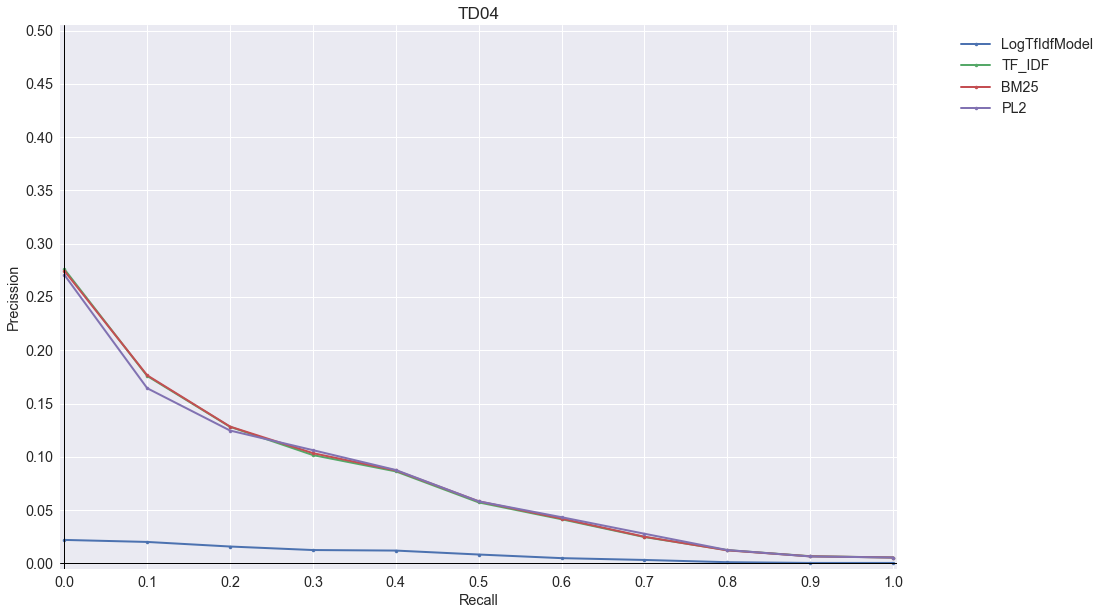

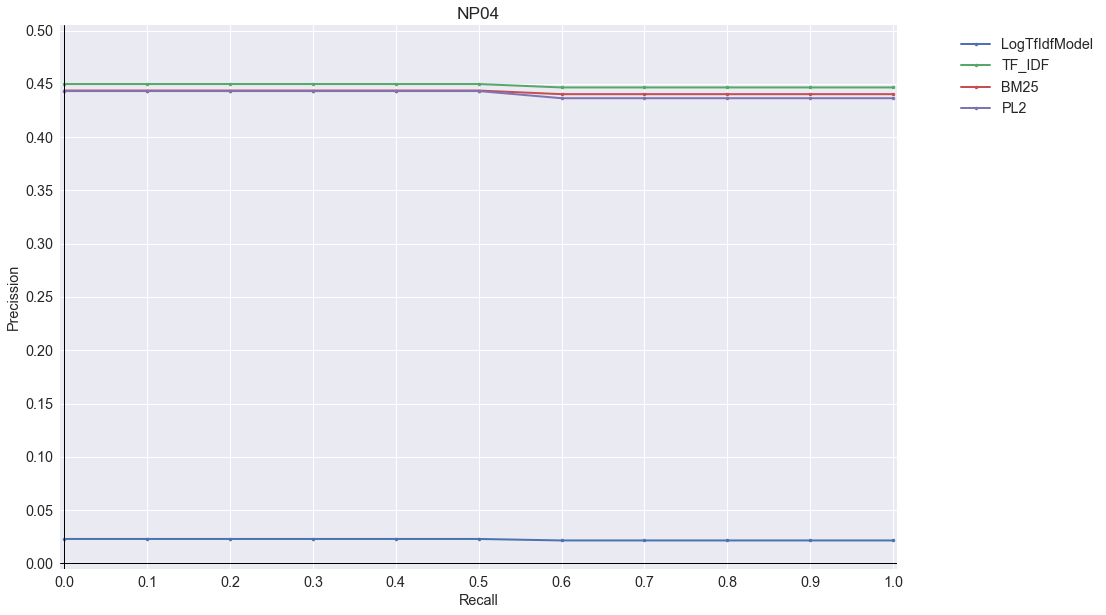

In [28]:
# Plot HP04
topic = 'HP04'
data = [aggregates[topic][model] for model in models]
plot_broken(data, models, topic,0.0, 0.2, 0.035)
plt.savefig(os.path.join(quiz_images, "map-%s.png" % topic), bbox_inches='tight')
plt.show();

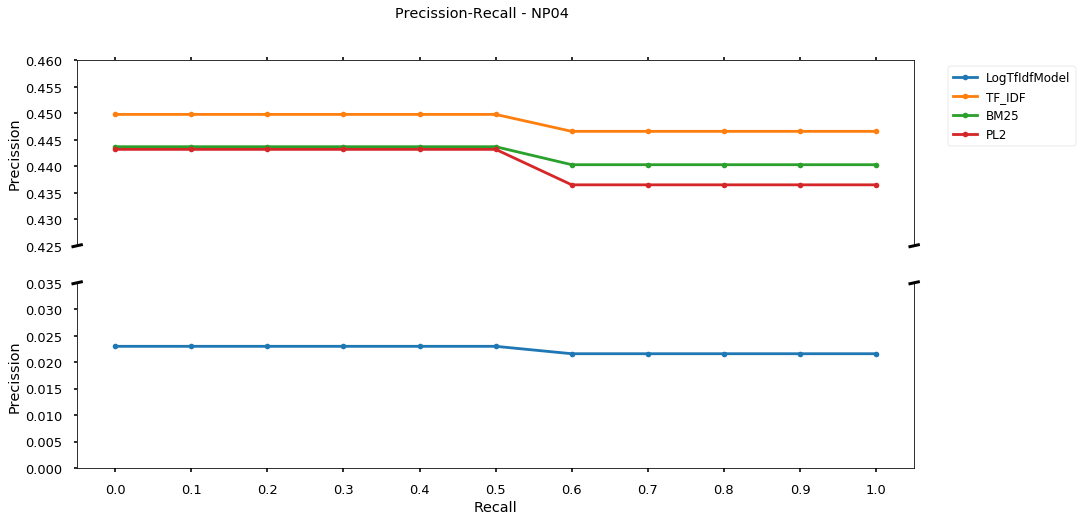

In [29]:
# Plot HP04
topic = 'NP04'
data = [aggregates[topic][model] for model in models]
plot_broken(data, models, topic,0.0, 0.425, 0.035)
plt.savefig(os.path.join(quiz_images, "map-%s.png" % topic), bbox_inches='tight')
plt.show();

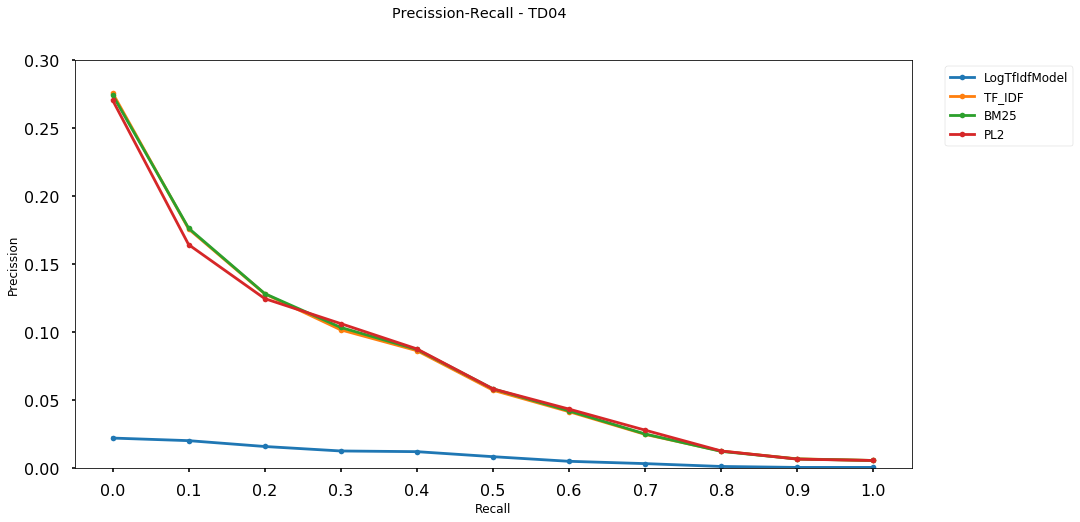

In [30]:
# Plot TD04
topic = 'TD04'
data = [aggregates[topic][model] for model in models]
plot_not_broken(data, models, topic,0.0, 0.3)
plt.savefig(os.path.join(quiz_images, "map-%s.png" % topic), bbox_inches='tight')
plt.show();

**[1 mark]**  

Finally, you should now answer on the quiz the most effective weighting model (in terms of Mean Average Precision), which you will use for the rest of Exercise 1. To identify this model, simply identify the weighting model with the highest average performance across the 3 topic sets.

 > Best performance was presented by the PL2 model

In [31]:
best_model = 'PL2'

## Q4
You will now conduct the Query Expansion experiments using the weighting model that produces the highest Mean Average Precision (MAP) across the 3 topic sets in Q3.  

Query expansion has a few parameters, e.g. query expansion model, number of documents to analyse, number of expansion terms – you should simply use the default query expansion settings of Terrier: Bo1, 3 documents, 10 expansion terms.  

**[6 marks]**

First, run the best weighting model you identified in Q3 with Query Expansion on the homepage finding (HP04), named page finding (NP04), and topic distillation (TD04) topic sets. Report the obtained MAP performances in the Quiz instance. Report your MAP performances to 4 decimal places.

In [32]:
avg = 0
for t in tp:
    model_avg = aggregates_qe[t][best_model].iloc[0]['map']
    avg = avg + model_avg
    print("With query expansion %s - %s: %.4f" % (t, 
                             best_model, 
                             model_avg))
print()
overall_avg = avg / 3
print("Performance for model %s with query expansion: %.4f" % (best_model, overall_avg))

With query expansion HP04 - PL2: 0.2423
With query expansion NP04 - PL2: 0.4442
With query expansion TD04 - PL2: 0.0671

Performance for model PL2 with query expansion: 0.2512


**[3 marks]**

Next, for each topic set (HP04, NP04, TD04) draw a single Recall-Precision graph comparing the performances of your system with and without the application of Query Expansion. Upload these graphs into the Quiz instance.

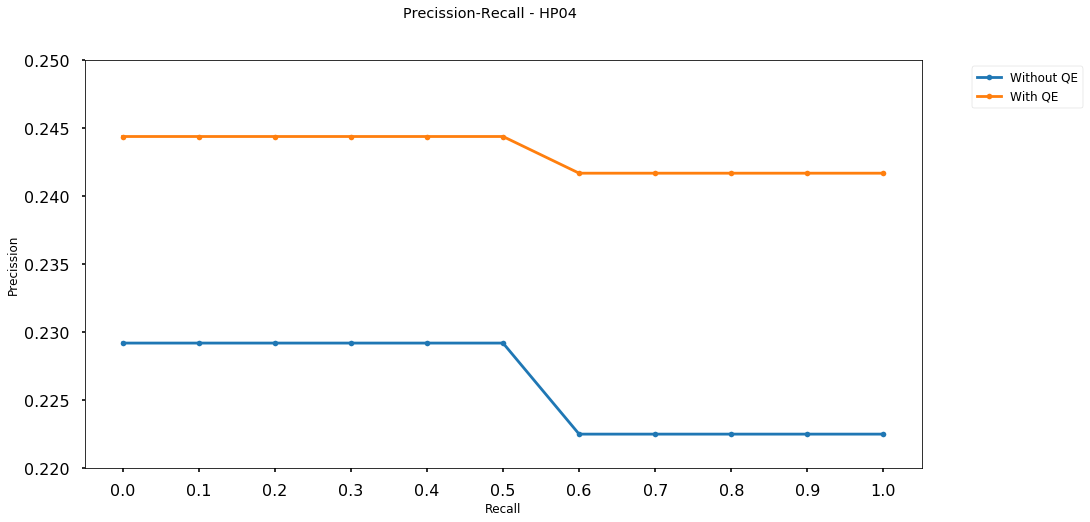

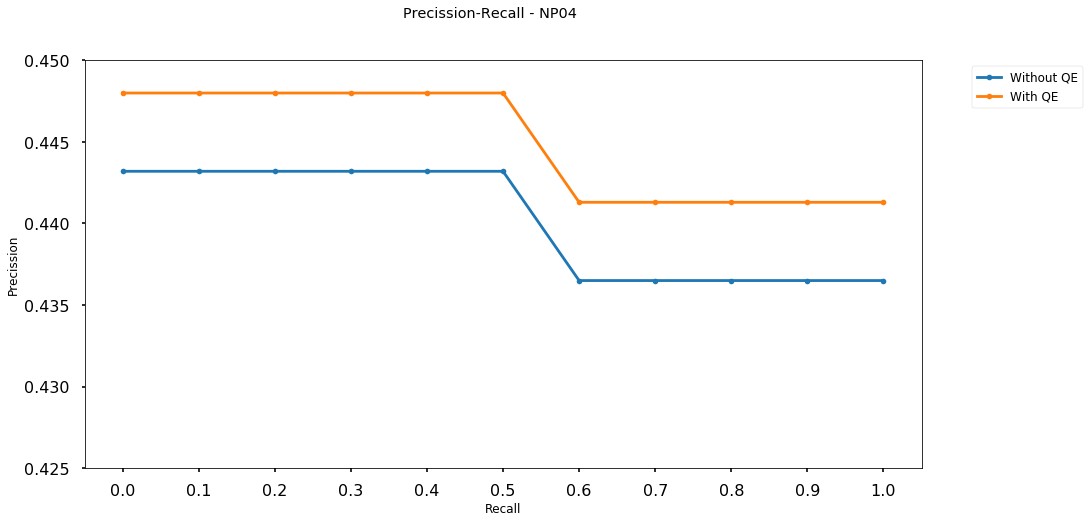

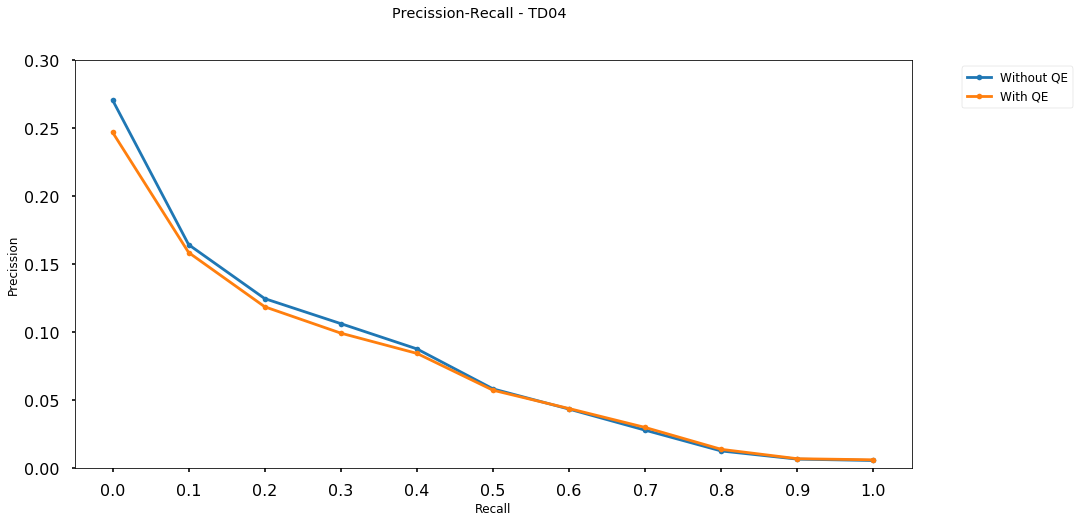

In [33]:
topic_limits = {
'HP04' : (0.22, 0.25),
'NP04' : (0.425, 0.45),
'TD04' : (0.0, 0.3)
}

for topic in topic_limits:
    limits = topic_limits[topic]
    
    p_q = aggregates[topic][best_model]
    p_q_qe = aggregates_qe[topic][best_model]

    plot_not_broken([p_q, p_q_qe],['Without QE', 'With QE'], topic, limits[0], limits[1])
    plt.savefig(os.path.join(quiz_images, "map-query-%s-%s.png" % (topic, best_model)), bbox_inches='tight')
    plt.show();
    

**[6 marks]**

Now, for each topic set (HP04, NP04, TD04) draw a separate query-by-query histogram comparing the MAP performance of your system with and without query expansion. The histogram should show for each query of the topic set two bars: one bar corresponding to the MAP performance of the system on that given query with query expansion and one bar corresponding to the MAP performance of the system on that given query without query expansion. Using these histograms and their corresponding data, you should now be able to answer the corresponding questions of the Quiz instance.

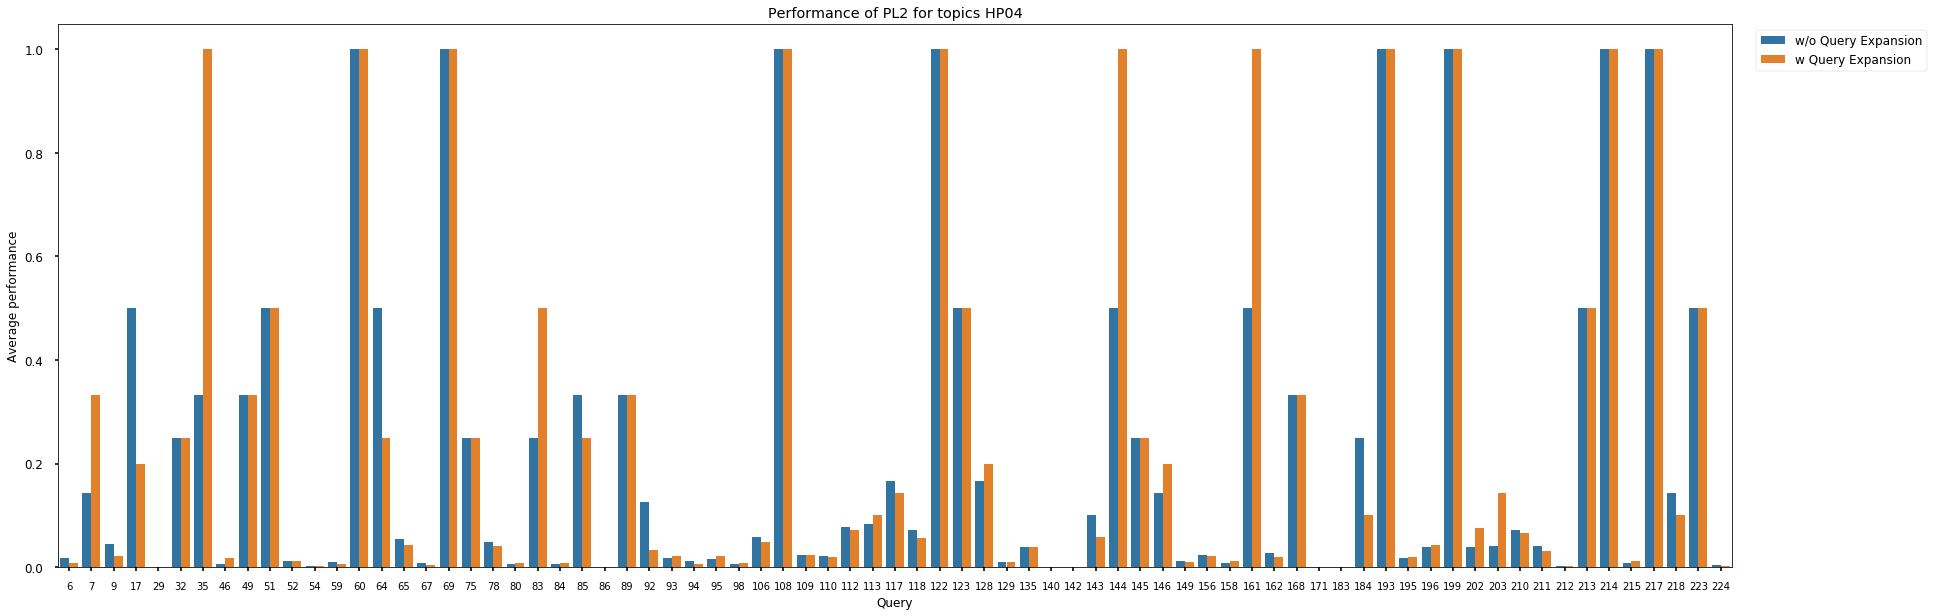

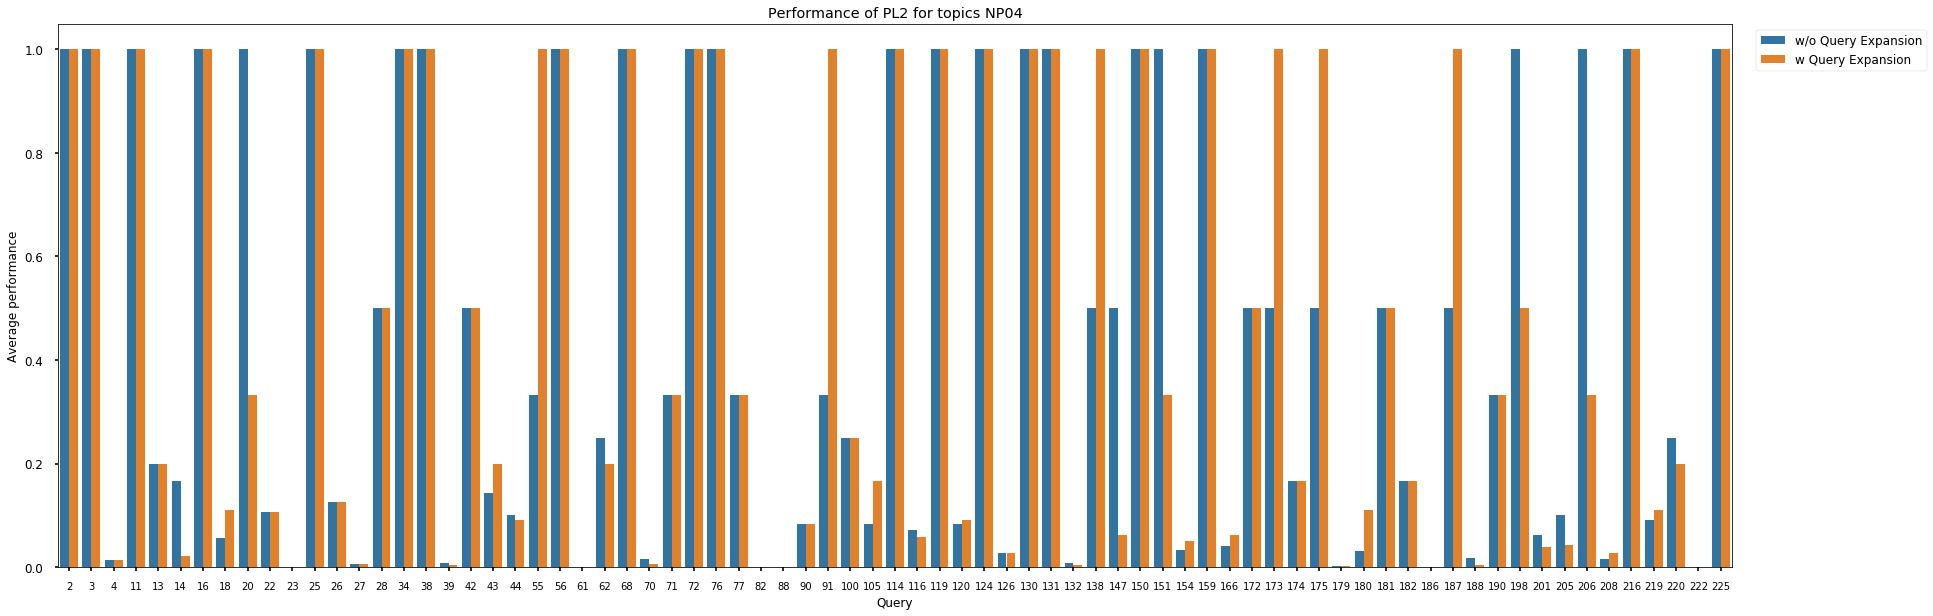

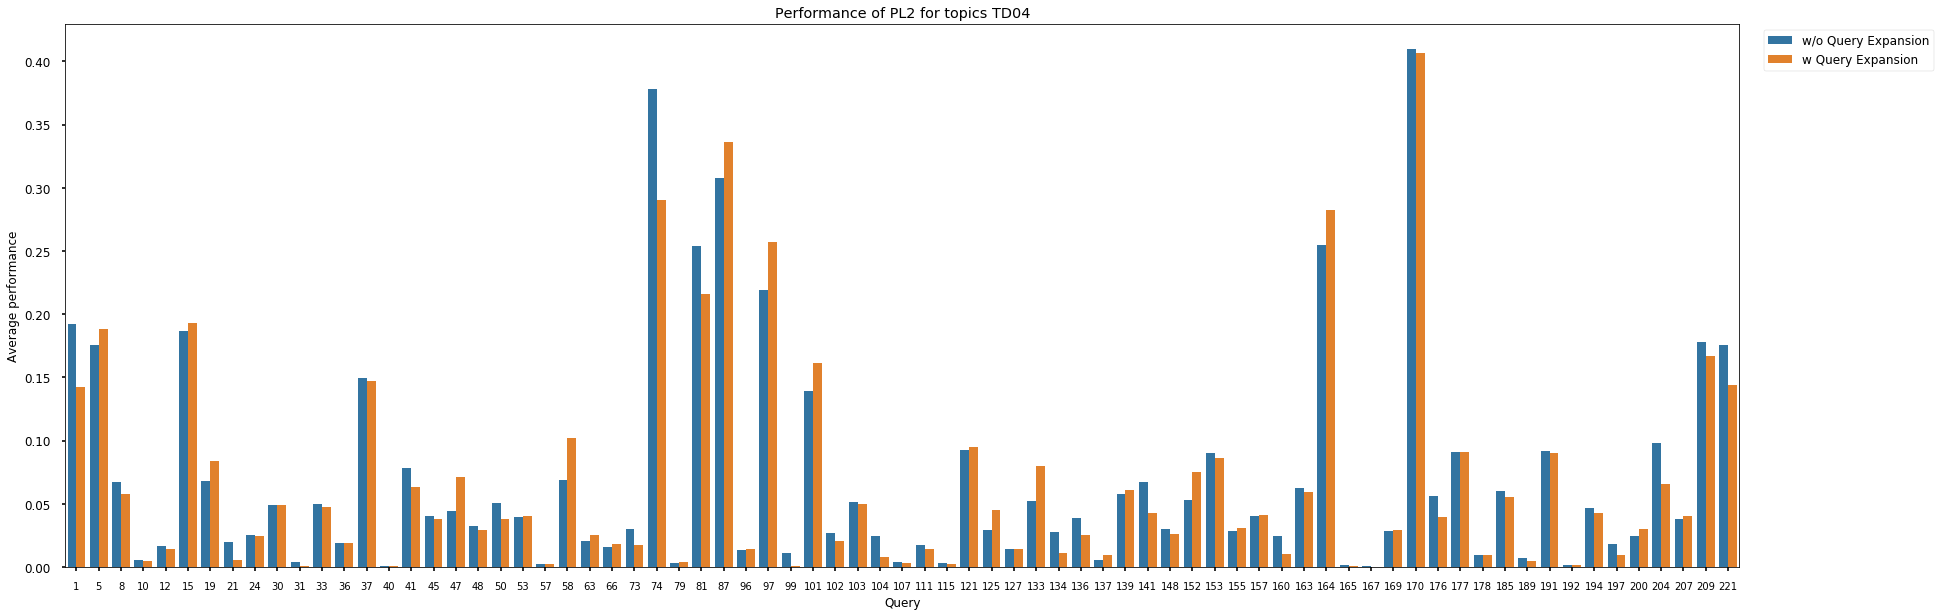

In [34]:
for topic in tp:
    p_q = per_query[topic][best_model]
    p_q['type'] = "w/o Query Expansion"
    p_q_qe = per_query_qe[topic][best_model]
    p_q_qe['type'] = "w Query Expansion"

    joint = pd.concat([p_q, p_q_qe]).reset_index()

    plt.figure(figsize=(30,10))
    plt.title("Performance of %s for topics %s" % (best_model, topic), size='x-large')
    sns.barplot(x='query', y='map', hue='type',data=joint)
    plt.yticks(size='large')
    plt.xticks(size='medium')
    plt.ylabel("Average performance", size='large')
    plt.xlabel("Query", size='large')
    plt.legend(loc='upper right', bbox_to_anchor=(1.12, 1.0), fontsize='large')
    
    plt.savefig(os.path.join(quiz_images, "map-query-bars-%s-%s.png" % (topic, best_model)), bbox_inches='tight')
    plt.show();